In [1]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread, imshow
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm             
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xml.etree.ElementTree as ET

In [38]:
#
# Load data
#

img_dir = "Dataset/images/Images"
ant_dir = "Dataset/annotations/Annotation"
X=[] #input array
Y=[] #output array

bnd_dict = {}

# Load annotations
label_count = 0
for sub_dir in os.listdir(ant_dir):
    label_count += 1
    label = sub_dir.split("-")[1]
    print(label)
    path=os.path.join(ant_dir,sub_dir)
    for ant in os.listdir(path):
        if ant[0] != 'n': continue
        tree = ET.parse(os.path.join(path,ant))
        root = tree.getroot()
        bndbox = root.find("object").find("bndbox")
        xmin = int(bndbox.findtext("xmin"))
        ymin = int(bndbox.findtext("ymin"))
        xmax = int(bndbox.findtext("xmax"))
        ymax = int(bndbox.findtext("ymax"))
        bnd_dict[ant] = [xmin, ymin, xmax, ymax]
    #if label_count >= 20: break
        
        
# Load images      
label_count = 0
for sub_dir in os.listdir(img_dir):
    label_count += 1
    label = sub_dir.split("-")[1]
    #print(label)
    path=os.path.join(img_dir,sub_dir)
    for img in os.listdir(path):
        if img[0] != 'n': continue
        img_array=imread(os.path.join(path,img))
        #imshow(img_array)
        #plt.show()
        bnd = bnd_dict[img.split(".")[0]]         
        img_bnd = img_array[bnd[1]:bnd[3],bnd[0]:bnd[2]]  # Use bndbox to crop image
        #imshow(img_bnd)
        #plt.show()
        #print(img_bnd)
        img_resized=resize(img_bnd,(227, 227, 3))#(150,150,3))
        #print(img_resized)
        X.append(img_resized)#.flatten()) # don't flatten it if CNN
        Y.append(label_count-1)
        
        img_fliplr = np.fliplr(img_resized)
        X.append(img_fliplr)#.flatten())
        Y.append(label_count-1)
        
        img_flipud = np.flipud(img_resized)
        X.append(img_flipud)#.flatten())
        Y.append(label_count-1)
        
    print(f'loaded category:{label} successfully')
    #if label_count >= 20: break

X=np.array(X)#.astype('float16')
Y=np.array(Y)#.astype('float16')
print(X.shape)
print(Y.shape)

Chihuahua
Japanese_spaniel
Maltese_dog
Pekinese
Shih
Blenheim_spaniel
papillon
toy_terrier
Rhodesian_ridgeback
Afghan_hound
basset
beagle
bloodhound
bluetick
black
Walker_hound
English_foxhound
redbone
borzoi
Irish_wolfhound
Italian_greyhound
whippet
Ibizan_hound
Norwegian_elkhound
otterhound
Saluki
Scottish_deerhound
Weimaraner
Staffordshire_bullterrier
American_Staffordshire_terrier
Bedlington_terrier
Border_terrier
Kerry_blue_terrier
Irish_terrier
Norfolk_terrier
Norwich_terrier
Yorkshire_terrier
wire
Lakeland_terrier
Sealyham_terrier
Airedale
cairn
Australian_terrier
Dandie_Dinmont
Boston_bull
miniature_schnauzer
giant_schnauzer
standard_schnauzer
Scotch_terrier
Tibetan_terrier
silky_terrier
soft
West_Highland_white_terrier
Lhasa
flat
curly
golden_retriever
Labrador_retriever
Chesapeake_Bay_retriever
German_short
vizsla
English_setter
Irish_setter
Gordon_setter
Brittany_spaniel
clumber
English_springer
Welsh_springer_spaniel
cocker_spaniel
Sussex_spaniel
Irish_water_spaniel
kuvasz


In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, TensorDataset
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

In [39]:
# 
# Data shuffle and build dataloader
#

tensor_x = torch.Tensor(X) # transform to torch tensor
tensor_x = torch.swapaxes(tensor_x, 2, 3)
tensor_x = torch.swapaxes(tensor_x, 1, 2)
print(tensor_x.size())
tensor_y = torch.Tensor(Y).type(torch.LongTensor)
print(tensor_y.size())

dataset = TensorDataset(tensor_x,tensor_y)
train_size = int(X.shape[0]*0.8)
val_size = int(X.shape[0]*0.1)
test_size = X.shape[0] - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])


#passing the train, val and test datasets to the dataloader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

torch.Size([61740, 3, 227, 227])
torch.Size([61740])


In [40]:
#
# Train the model
#


device = 'cuda' # if you dont have a gpu, set device = cpu here
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model = model.to(device=device) #to send the model for training on either cuda or cpu

## Loss and optimizer
learning_rate = 5e-6
load_model = True
criterion = nn.CrossEntropyLoss()
val_acc = []
tr_loss = []

for epoch in range(200): # How many epochs?
    loss_ep = 0
    
    learning_rate = learning_rate * 0.99
    print("learning rate: ", learning_rate)
    
    for batch_idx, (data, targets) in enumerate(train_dl):
        #print(data.shape)
        data = data.to(device=device)
        targets = targets.to(device=device)
        optimizer = optim.Adam(model.parameters(), lr= learning_rate)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")
    tr_loss.append(loss_ep/len(train_dl))

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        val_acc.append(float(num_correct) / float(num_samples) * 100)

Using cache found in C:\Users\thego/.cache\torch\hub\pytorch_vision_v0.10.0


learning rate:  4.95e-06
Loss in epoch 0 :::: 5.516442637369423
Got 136 / 6174 with accuracy 2.20
learning rate:  4.9005e-06
Loss in epoch 1 :::: 4.52862737432045
Got 348 / 6174 with accuracy 5.64
learning rate:  4.851495e-06
Loss in epoch 2 :::: 4.091875611809251
Got 600 / 6174 with accuracy 9.72
learning rate:  4.80298005e-06
Loss in epoch 3 :::: 3.705695781374225
Got 889 / 6174 with accuracy 14.40
learning rate:  4.7549502495e-06
Loss in epoch 4 :::: 3.357034830540573
Got 1201 / 6174 with accuracy 19.45
learning rate:  4.7074007470049995e-06
Loss in epoch 5 :::: 3.0846231573603933
Got 1424 / 6174 with accuracy 23.06
learning rate:  4.660326739534949e-06
Loss in epoch 6 :::: 2.8593246470461238
Got 1659 / 6174 with accuracy 26.87
learning rate:  4.6137234721395995e-06
Loss in epoch 7 :::: 2.6697825387969534
Got 1828 / 6174 with accuracy 29.61
learning rate:  4.567586237418203e-06
Loss in epoch 8 :::: 2.5211053133937362
Got 2019 / 6174 with accuracy 32.70
learning rate:  4.521910375044

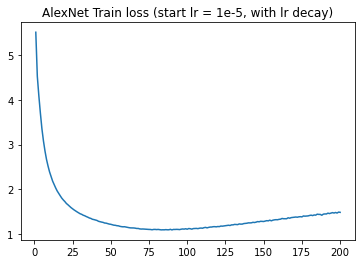

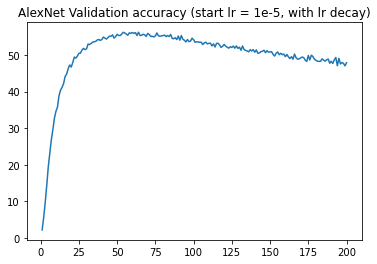

In [47]:
# Plots out train loss and validation accuracy
plt.title("AlexNet Train loss (start lr = 1e-5, with lr decay)")
plt.plot(list(range(1, len(tr_loss)+1)), tr_loss)

plt.show()

plt.title("AlexNet Validation accuracy (start lr = 1e-5, with lr decay)")
plt.plot(list(range(1, len(val_acc)+1)), val_acc)

plt.show()

In [46]:
# Prints out test accuracy
with torch.no_grad():
    num_correct = 0
    num_samples = 0
    for batch_idx, (data,targets) in enumerate(test_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        scores = model(data)
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
    print(
        f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
    )

Got 3017 / 6174 with accuracy 48.87
